# The Iterative Phase Estimation Algorithm 

## Overview 

- Type: Quantum subroutine for phase estimation
- Estimated difficulty: Intermediate
- Useful preliminaries: Phase Estimation compendium article
- Applications: Hardware constrained Phase Estimation
- Number of qubits: Size of $U$ and one auxiliary qubit. 
- Number of operations: $O(1/\text{precision})$ calls to the controlled-$U$. 
- Maximum depth: $O(1/\text{precision})$

Given a unitary $U$ with eigenvalue $e^{2\pi i \theta}$, the task of phase estimation is to determine the phase $\theta$ to precision $\epsilon$ with probability $1-\delta$. The Iterative Quantum Phase Estimation (IQPE) algorithm is a procedure which is equivalent to standard QPE, but uses multiple rounds of measurement. Although it is one of many iterative QPE algorithms, the one described in this article is often considered "the" iterative QPE algorithm, due to its popularity and it being derived from standard QPE through a simple transformation. However, this does not mean IQPE outperforms other iterative methods.

The promise of IQPE, as opposed to standard QPE, is fewer auxiliary qubits and less demanding quantum operations. This is particularly attractive in the current era of limited quantum hardware (at time of writing, 2023).  

By "iterative," we mean that a similar set of quantum operations is applied over and over. IQPE is *adaptive* in the sense that subsequent iterations will depend on the measurement results of previous ones. The normal version of this procedure works even when the input state is a general superposition of eigenstates. A restricted but less-demanding "incoherent" version involves resetting the main register following each measurement. This reduces the maximum circuit depth, but only works when the main register is in an approximate eigenstate of $U$.

## Description

If you are already familiar with standard Quantum Phase Estimation, you may prefer to start with section "Equivalence to standard QPE."

The algorithm proceeds by learning one bit of $\theta$ at a time, starting from the least significant bit. To obtain $m$ bits of precision we must do $m$ repetitions. Each repetition involves measuring an auxiliary qubit to obtain one bit in a binary expansion of $\theta$. By the end of the procedure, we have, with high probability of success, an $m$ bit approximation $0.\theta_1\theta_2\dots\theta_m$ of $\theta$.

### The basic iteration

**Ferris-IQPEA-circuit**

The circuit above shows the $k$th iteration of the algorithm, where $k = 1, 2, \dots m$. For simplicity, suppose the main register is in eigenstate $\vert\psi\rangle = \vert u\rangle$, and also assume $\theta$ is truly an $m$ bit string $0.\theta_1\theta_2\dots\theta_m$. Applying the first Hadamard and controlled-$U^{2^{m-k}}$ gives the state 

$$
\left(\vert0\rangle + e^{2\pi i \theta 2^{m-k}}\vert1\rangle\right)\otimes \vert u\rangle
$$ 

up to normalization. The power $2^{m-k}$ serves to eliminate the first $m-k$ bits from $\theta$ by pushing them in front of the decimal point, where they become irrelevant due to $2\pi$ periodicity of the phase. 

$$
\begin{aligned}
\exp \left(2\pi i 0.\theta_1\dots\theta_m 2^{m-k}\right) &= \exp \left(2\pi i \theta_1\dots\theta_{m-k}.\theta_{m-k+1}\dots\theta_m\right) = \exp \left(2\pi i 0.\theta_{m-k+1}\dots\theta_m\right)
\end{aligned}
$$

Next, we come to the classically controlled rotations. The rotation angles are chosen to eliminate all but the first bit $\theta_{m-k+1}$ in the remaining bitstring. This stage is where the previously measured values $\theta_{m-k+2}, \dots, \theta_m$ come into play. Following these controlled rotations, our auxiliary qubit is in state

$$
\vert0\rangle + e^{2\pi i 0.\theta_{m-k+1}}\vert1\rangle
$$

up to normalization. The final Hadamard puts us in the computational basis state

$$
\vert\theta_{m-k+1}\rangle
$$

and the value of the bit $\theta_{m-k+1} \in \{0,1\}$ can be measured and stored for later iterations. The auxiliary qubit is then reset to $\vert0\rangle$, and in the incoherent version the main register would be reset to its initial value. The $(k+1)$th iteration commences, and so on until all bits $\theta_m, \theta_{m-1}, \dots, \theta_1$ are measured (in that order).

## Details and commentary

The algorithm behaves identically to standard QPE, because the circuits for the two procedures are formally equivalent. See the next section for further details. However, available quantum resources and imperfections in hardware may dictate the choice of one approach versus the other.

Though the above analysis was done for eigenstate inputs $\vert u\rangle$ and $\theta$ a binary string, the procedure works more generally. When the input state $\vert\psi\rangle$ is a superposition of eigenstates, normal IQPE will return one of the eigenphases with probability approximately given by the Born rule. The incoherent version only works for approximate eigenstates. 

When $\theta \in [0,1)$ is arbitrary, the closest $m$ bit approximation $\tilde{\theta} = 0.\theta_1\dots\theta_m$ is obtained with reasonably high probability. This probability can be boosted with several trials.

Because measurements are intrinsic to this procedure, the resulting phase estimate is necessarily stored in a classical register, and therefore superpositions of phases cannot be accommodated. This precludes the use of IQPEA as an intermediate subroutine for later quantum calculations. As an important example, IQPEA could not be used as part of the HHL algorithm for linear systems, because the inversion $\theta \mapsto 1/\theta$ needs to be performed on general superpositions $\sum_i c_i \vert\theta_i\rangle$ of phases obtained from a QPE protocol.

## Equivalence to standard QPE

IQPE is formally equivalent to standard QPE. The key idea to understand this is to look closer at the inverse Quantum Fourier Transform at the end of the standard QPE circuit. 

**Put diagram here of iQFT with measurements gates**. 

The controlled phase gates in this diagram are quantum controls, but they don't have to be. We can create an equivalent circuit by pushing the measurements in front of the phase gate wherever possible, swapping the quantum control for a classical one.

**switch-measure-control**

Next, we can put each of the parallel auxiliary wires "in series" by repeated applying the following circuit equivalence. 

**parallel-to-iterative diagram**

This relation reduces the number of qubits by one each time, and at the end we are left with a single auxiliary qubit. 

### Qiskit implementation

#### Relevant imports

In [2]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library.standard_gates import SwapGate, TGate # For demonstrations

#### Define the circuit

In [3]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def iterative_QPE_circuit(U, precision = 2**-4, coherent = True):
    """
    Args:
        U (Gate): Unitary gate in phase estimation problem
        precision (float): Desired precision of final phase estimate
        coherent (bool): If true, retains state of main register following each measurement. 
        Otherwise, all registers are reset to initial values following each measurement. 
    Returns:
        QuantumCircuit that implements Iterative QPE
    """
    cU = U.control(1)
    bits_precision = int(np.ceil(np.log2(1/precision)))
    
    # Construct registers and circuit
    cr = ClassicalRegister(bits_precision, r'$\varphi$')
    aux = QuantumRegister(1, 'aux')
    main = QuantumRegister(U.num_qubits, 'q')
    QPE_circ = QuantumCircuit(aux, main, cr)

    
    for bit in range(bits_precision -1, -1,-1):
        QPE_circ.h(0)
        QPE_circ.append(U.repeat(2**bit).control(1), aux[:] + main[:])
        
        # Controlled phases loop
        for b in range(bit +1, bits_precision):
            k = (b - bit) + 1
            QPE_circ.p(-(2*np.pi)/2**k,0).c_if(b,1)
        
        QPE_circ.h(0)
        
        # Measure, store result, reset
        QPE_circ.measure(0, bit)
        QPE_circ.reset(0)
        
        # Reset all qubits if not coherent
        if not coherent: 
            QPE_circ.reset(main[:])
            QPE_circ.barrier()
            
    return QPE_circ

### Illustrate the circuit with SWAP

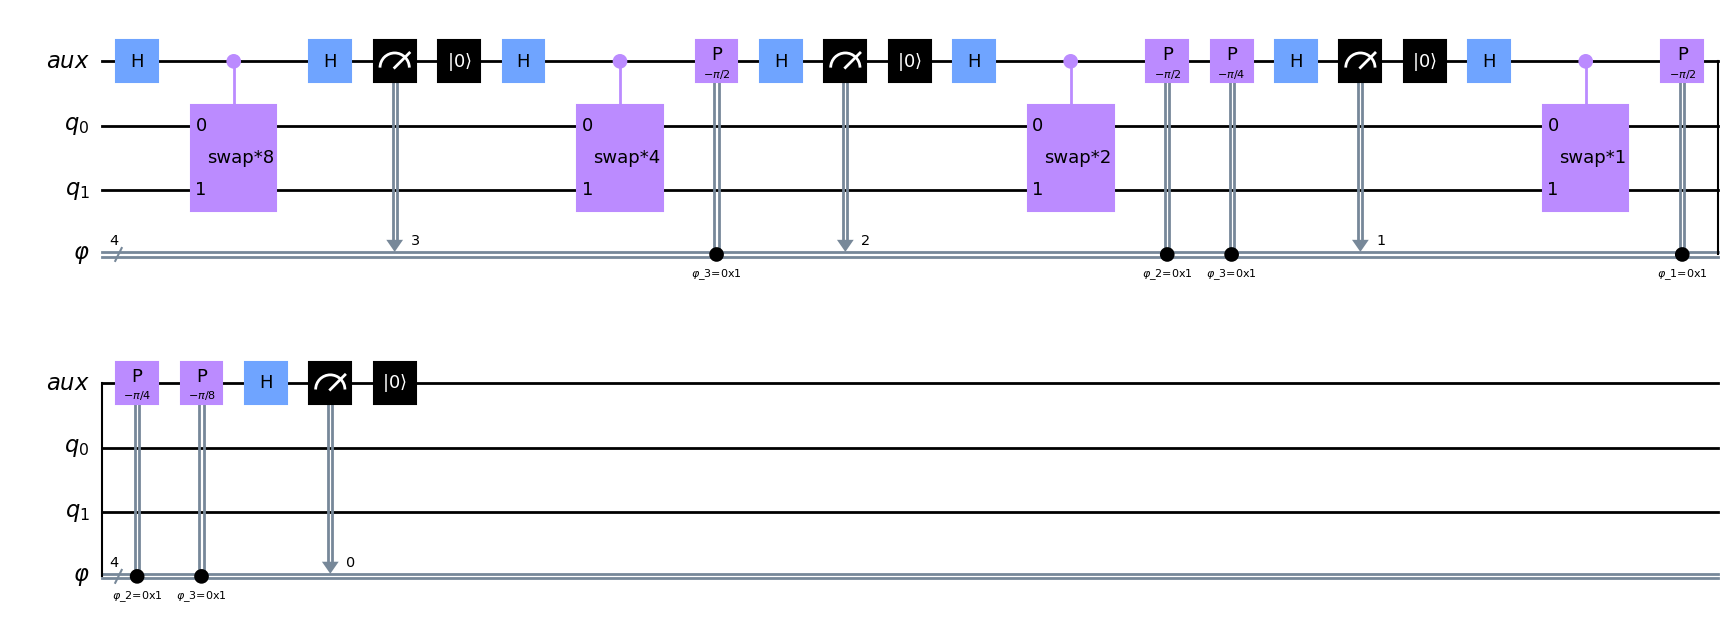

In [4]:
from qiskit.circuit.library import SwapGate

iterative_QPE_circuit(SwapGate()).draw(output = 'mpl')

Now we test our circuit to estimate the phase of the $T$ gate corresponding to the $\vert 1\rangle$ eigenstate. The answer $\theta$ we expect can be found by equating

$$
2\pi\theta = \pi/4
$$
i.e. $\theta = 1/8$. This is indeed the answer we get below, whether we do coherent or incoherent evolution (they are equivalent here since $\vert1\rangle$ is a perfect eigenstate). Since $\theta$ is a binary fraction, we should always get an exact answer with a sufficient number of auxiliary qubits.

In [5]:
precision = 10**-2

# State preparation for |1> state
prep = QuantumCircuit(1)
prep.x(0)

# Create circuit for IQPE with state preparation
IQPE = iterative_QPE_circuit(TGate(), precision = precision, coherent = True)
IQPE.compose(prep, qubits = range(1,IQPE.num_qubits),front = True, inplace = True)

# Execute circuit
job = Sampler().run(IQPE, shots = 1)
result_dict = job.result().quasi_dists[0].binary_probabilities()
measurement = list(job.result().quasi_dists[0].binary_probabilities())[0]

# Our ordering convention here is opposite of Qiskit. Reverse string.
measurement = measurement[::-1]

# Convert binary string to a float
phase = int(measurement,2)/2**len(measurement)

print("Estimate of phase:", phase)
print("To precision:", precision) 

Estimate of phase: 0.125
To precision: 0.01


### References and resources

- Ferris, [2023 Qiskit Global Summer School](https://www.youtube.com/watch?v=aLSM0_H8hUE)
- IBM Learning Platform, [Iterative Phase Estimation](https://learning.quantum-computing.ibm.com/tutorial/iterative-phase-estimation)